In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

# Datasets

In [2]:
# get data sets
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../Data_sets/MNIST_data', one_hot=True)

Extracting ../Data_sets/MNIST_data\train-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\train-labels-idx1-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-images-idx3-ubyte.gz
Extracting ../Data_sets/MNIST_data\t10k-labels-idx1-ubyte.gz


# Build weight & bias initializer by name

In [3]:
def get_initial_weights_bias_by_name(name):
    mean = 0.0
    stddev = 0.1
    dtype = tf.float32
    if name == 'normal':
        w_init = tf.random_normal_initializer(mean=mean, stddev=stddev, dtype=dtype)
    elif name == 'truncated':
        w_init = tf.truncated_normal_initializer(mean=mean, stddev=stddev, dtype=dtype)
    elif name == 'xavier':
        #w_init = tf.contrib.layers.variance_scaling_initializer(factor=1.0, mode='FAN_AVG', uniform=True, dtype=dtype)
        w_init = tf.contrib.layers.xavier_initializer(uniform=True, dtype=dtype)
    elif name == 'he':
        w_init = tf.contrib.layers.variance_scaling_initializer(factor=2.0, mode='FAN_IN', uniform=False, dtype=dtype)
    
    b_init = tf.zeros_initializer(dtype=dtype)
    return w_init, b_init

# Model builder functions

In [4]:
def model_inputs(n_input, n_output):
    with tf.name_scope('placeholders'):
        inputs = tf.placeholder(tf.float32, shape=[None, n_input], name='inputs')
        labels = tf.placeholder(tf.float32, shape=[None, n_output], name='labels')
    
    return inputs, labels

In [5]:
def mlp_with_batch_norm(inputs, n_hidden, n_output, param_init_type, is_training=True):
    with tf.variable_scope('with_batch_norm'):
        # get weights & bias
        w_init, b_init = get_initial_weights_bias_by_name(param_init_type)
        h1 = tf.layers.dense(inputs=inputs, units=n_hidden, activation=None, kernel_initializer=w_init, bias_initializer=b_init)
        h1 = tf.layers.batch_normalization(inputs=h1, training=is_training)
        h1 = tf.nn.relu(h1)

        h2 = tf.layers.dense(inputs=h1, units=n_hidden, activation=None, kernel_initializer=w_init, bias_initializer=b_init)
        h2 = tf.layers.batch_normalization(inputs=h2, training=is_training)
        h2 = tf.nn.relu(h2)

        logits = tf.layers.dense(inputs=h2, units=n_output, activation=None, kernel_initializer=w_init, bias_initializer=b_init)
    
    return logits  

In [6]:
def mlp_without_batch_norm(inputs, n_hidden, n_output, param_init_type, is_training=True):
    with tf.variable_scope('without_batch_norm'):
        # get weights & bias
        w_init, b_init = get_initial_weights_bias_by_name(param_init_type)
        h1 = tf.layers.dense(inputs=inputs, units=n_hidden, activation=tf.nn.relu, kernel_initializer=w_init, bias_initializer=b_init)
        h2 = tf.layers.dense(inputs=h1, units=n_hidden, activation=tf.nn.relu, kernel_initializer=w_init, bias_initializer=b_init)
        logits = tf.layers.dense(inputs=h2, units=n_output, activation=None, kernel_initializer=w_init, bias_initializer=b_init)
    
    return logits

In [7]:
def model_loss_acc(inputs, labels, n_hidden, n_output, param_init_type='normal', use_batch_norm=False):
    if use_batch_norm:
        logits = mlp_with_batch_norm(inputs, n_hidden, n_output, param_init_type, is_training=True)
    else:
        logits = mlp_without_batch_norm(inputs, n_hidden, n_output, param_init_type, is_training=True)
    
    with tf.name_scope('cost'):
        # compute loss
        loss = tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels), name='loss' )
        tf.summary.scalar(name='loss', tensor=loss)
    
    with tf.name_scope('predictions'):
        # compute accuracy
        correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(labels, 1))
        acc = tf.reduce_mean( tf.cast(correct_prediction, tf.float32), name='accuracy' )
        tf.summary.scalar(name='accuracy', tensor=acc)
    
    return loss, acc

In [8]:
def model_opt(loss, learning_rate, use_batch_norm=False):
    with tf.name_scope('train'):
        if use_batch_norm:
            # take care of batch norm
            with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
                opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
        else:
            opt = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
    return opt

In [9]:
class TestNet:
    def __init__(self, n_input, n_output, n_hidden, learning_rate, param_init_type, use_batch_norm):
        tf.reset_default_graph()
        
        self.inputs, self.labels = model_inputs(n_input, n_output)
        self.loss, self.acc = model_loss_acc(self.inputs, self.labels, n_hidden, n_output, param_init_type, use_batch_norm)
        self.optimizer = model_opt(self.loss, learning_rate, use_batch_norm)
        self.merged_summary = tf.summary.merge_all()

In [10]:
def train(net, epochs, batch_size, print_every, training_name):
    losses = []
    accrucacies = []
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        train_writer = tf.summary.FileWriter('./logs/' + training_name, sess.graph)
        
        for e in range(epochs):
            for ii in range(mnist.train.num_examples//batch_size):
                steps += 1
                
                # get input data
                batch_x, batch_y = mnist.train.next_batch(batch_size)
                
                # run optimizer
                _, train_loss, train_acc, summary = sess.run([net.optimizer, net.loss, net.acc, net.merged_summary], 
                                                             feed_dict={net.inputs: batch_x, net.labels: batch_y})
                
                train_writer.add_summary(summary, steps)
                
                # for saving results
                losses.append(train_loss)
                accrucacies.append(train_acc)
                
                # print
                if steps % print_every == 0:
                    print("Epoch {}/{}...".format(e+1, epochs), "Loss: {:.4f}...".format(train_loss), "Acc: {:.4f}...".format(train_acc))
    
    return losses, accrucacies

# Training

In [11]:
# network params
n_input = 784
n_hidden = 256
n_classes = 10

# train params
training_epochs = 15
batch_size = 100
display_step = 1000
learning_rate = 0.001

In [12]:
# first create dictionary to hold training result
results = {
    'normal.false': { 'loss': [], 'acc': [] },
    'normal.true': { 'loss': [], 'acc': [] },
    'truncated.false': { 'loss': [], 'acc': [] },
    'truncated.true': { 'loss': [], 'acc': [] },
    'xavier.false': { 'loss': [], 'acc': [] },
    'xavier.true': { 'loss': [], 'acc': [] },
    'he.false': { 'loss': [], 'acc': [] },
    'he.true': { 'loss': [], 'acc': [] } }

In [14]:
# train on every test settings
param_init_list = ['normal', 'truncated', 'xavier', 'he']
use_batch_norm_list = [True, False]

for init_name in param_init_list:
    for use_BN in use_batch_norm_list:
        # create dictionary key
        result_dict_key = init_name + '.' + str(use_BN).lower()
        print('[Running]: {}!!!'.format(result_dict_key))
        
        # create network
        net = TestNet(n_input, n_classes, n_hidden, learning_rate, init_name, use_BN)
        
        # save trainint result
        results[result_dict_key]['loss'], results[result_dict_key]['acc'] = train(net, training_epochs, batch_size, display_step, result_dict_key)

[Running]: normal.true!!!
Epoch 2/15... Loss: 0.0685... Acc: 0.9800...
Epoch 4/15... Loss: 0.0217... Acc: 0.9900...
Epoch 6/15... Loss: 0.0058... Acc: 1.0000...
Epoch 8/15... Loss: 0.0103... Acc: 0.9900...
Epoch 10/15... Loss: 0.0049... Acc: 1.0000...
Epoch 11/15... Loss: 0.0313... Acc: 0.9800...
Epoch 13/15... Loss: 0.0097... Acc: 1.0000...
Epoch 15/15... Loss: 0.0070... Acc: 1.0000...
[Running]: normal.false!!!
Epoch 2/15... Loss: 0.0707... Acc: 0.9600...
Epoch 4/15... Loss: 0.0221... Acc: 0.9900...
Epoch 6/15... Loss: 0.0501... Acc: 0.9700...
Epoch 8/15... Loss: 0.0066... Acc: 1.0000...
Epoch 10/15... Loss: 0.0086... Acc: 1.0000...
Epoch 11/15... Loss: 0.0245... Acc: 0.9800...
Epoch 13/15... Loss: 0.0189... Acc: 0.9900...
Epoch 15/15... Loss: 0.0355... Acc: 0.9900...
[Running]: truncated.true!!!
Epoch 2/15... Loss: 0.0787... Acc: 0.9800...
Epoch 4/15... Loss: 0.0153... Acc: 1.0000...
Epoch 6/15... Loss: 0.0224... Acc: 1.0000...
Epoch 8/15... Loss: 0.0077... Acc: 1.0000...
Epoch 10/1

In [15]:
for k, v in results.items():
    if isinstance(v, dict):
        print('name: {}, loss: {}, acc: {}'.format(k, len(v['loss']), len(v['acc'])))

name: truncated.true, loss: 8250, acc: 8250
name: normal.false, loss: 8250, acc: 8250
name: he.true, loss: 8250, acc: 8250
name: normal.true, loss: 8250, acc: 8250
name: he.false, loss: 8250, acc: 8250
name: truncated.false, loss: 8250, acc: 8250
name: xavier.true, loss: 8250, acc: 8250
name: xavier.false, loss: 8250, acc: 8250


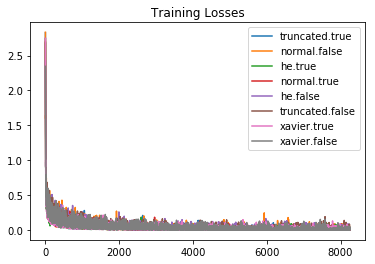

In [16]:
fig, ax = plt.subplots()
for k, v in results.items():
    if isinstance(v, dict):
        losses = np.array(v['loss'])
        plt.plot(losses, label=k)
plt.title("Training Losses")
plt.legend()

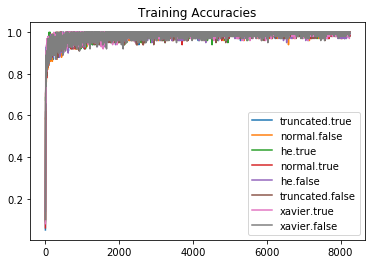

In [17]:
fig, ax = plt.subplots()
for k, v in results.items():
    if isinstance(v, dict):
        accuracy = np.array(v['acc'])
        plt.plot(accuracy, label=k)
plt.title("Training Accuracies")
plt.legend()